# **Classify Real and AI-Generated Synthetic Images**

by Amin Nazemzadeh, Chibueze Nwade, and Sean Fitzgerald

Introduction

In recent years image-creating AI technology has advanced rapidly. With DALL-E 2, midjourny, Dreamstudio, and more fake image AI models approximately 2 million AI generated images are created each day. This is incredible technology that can be used for a variety of interesting and helpful tasks. However, there are many dangers to AI generated images. 

Scams, misinformation, propaganda, plagiarism and identity theft are all common over the internet, and can be propelled forward with the use of image-faking AI. Being able to distinguish between real and fake images will help combat the negative uses of this technology. Our project is designed to differentiate between real and fake images, using a Convolutional Neural Network trained on a dataset of real and AI generated images. 

**The Dataset**

We are using the CIFAKE: Real and AI-Generated Synthetic Images dataset found on kaggle [here](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images). The database contains 60,000 real images collected from the CIFAR-10 database, and 60,000 fake images created from Stable Diffusion version 1.4. All images, real and fake, are resolution 32x32. So while these images are not the resolution of images we normally encounter, they provide enough information to begin tackling the issue.

In [1]:
%pip install tensorflow
%pip install pandas
%pip install numpy
%pip install requests
%pip install beautifulsoup4
import pandas
import numpy
import requests
from bs4 import BeautifulSoup
import tensorflow
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 335.1 kB/s eta 0:00:0000:0100:01
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2023-05-12 21:57:57.776672: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Wrangling

The data coming in was split into 2 folders, 1 for training and 1 for testing. Within each folder, there were two classes each image was associated with: FAKE and REAL. The dataset being organized on import is incredibly useful and made the data wrangling not a problem. Below we have displayed a portion of the training set. With the human eye there is no clear distinction between the real and fake images. This further proves the need for computer assistance in identifying fake images. 

In [2]:
path_to_training_directories = './archive/train'
path_to_test_images = './archive/test'
batch_size = 32
img_height = 32
img_width = 32

train_ds = tensorflow.keras.utils.image_dataset_from_directory(
  path_to_training_directories,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tensorflow.keras.utils.image_dataset_from_directory(
  path_to_test_images,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = train_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


2023-05-12 21:59:09.772719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100000]
	 [[{{node Placeholder/_4}}]]
2023-05-12 21:59:09.773616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100000]
	 [[{{node Placeholder/_0}}]]


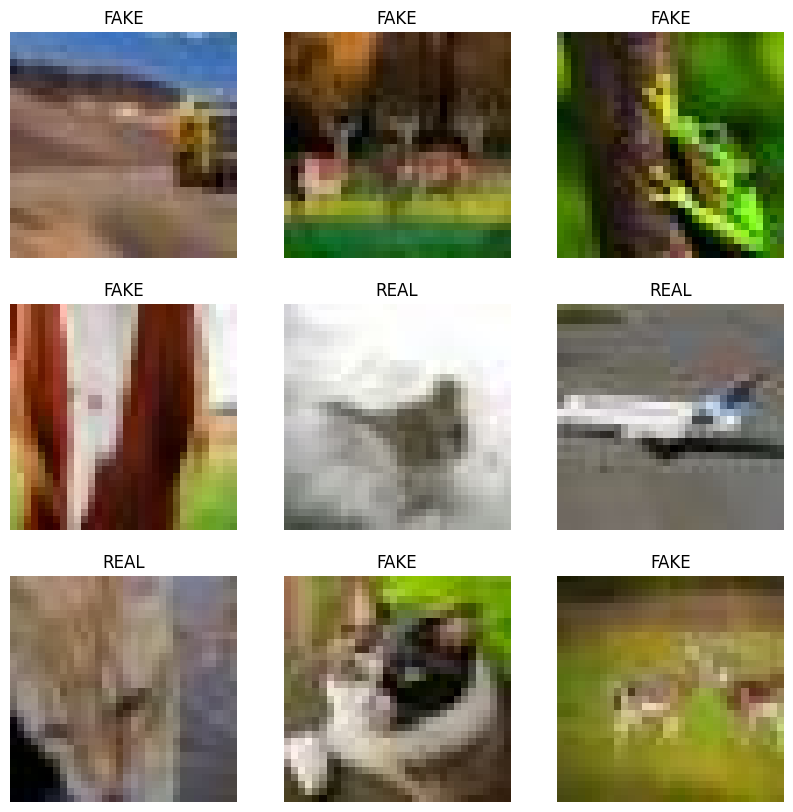

In [3]:
# lets test tensorflow tutorial first
# these are the first 9 images from training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Training

We are using the tesnorflow module to create our Convoltion Neural Network

In [4]:
# these are here to boost performance
# .cache keeps the images in memory after they're loaded off disk during the first epoch
# prefetch overlaps data preprocessing and model execution while training
AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
# RGB values are in the range of 0-255, we'll make it into range of 0-1
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

2023-05-12 21:59:11.355277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100000]
	 [[{{node Placeholder/_4}}]]
2023-05-12 21:59:11.357781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100000]
	 [[{{node Placeholder/_4}}]]
2023-05-12 21:59:24.108293: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input p

In [6]:
# now we create the model
# we have 3 convolution blocks, activation function in relu
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          1

In [7]:
epochs=3 # change to 10 or a big number for grapghs to work
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3


2023-05-12 21:59:27.048955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100000]
	 [[{{node Placeholder/_4}}]]
2023-05-12 21:59:27.050932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100000]
	 [[{{node Placeholder/_4}}]]


3125/3125 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.8848

2023-05-12 22:02:31.189574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [20000]
	 [[{{node Placeholder/_4}}]]
2023-05-12 22:02:31.191746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [20000]
	 [[{{node Placeholder/_0}}]]


3125/3125 [==============================] - 195s 57ms/step - loss: 0.2723 - accuracy: 0.8848 - val_loss: 0.1901 - val_accuracy: 0.9257
Epoch 2/3
3125/3125 [==============================] - 145s 47ms/step - loss: 0.1863 - accuracy: 0.9265 - val_loss: 0.2063 - val_accuracy: 0.9179
Epoch 3/3
3125/3125 [==============================] - 135s 43ms/step - loss: 0.1615 - accuracy: 0.9366 - val_loss: 0.1618 - val_accuracy: 0.9369


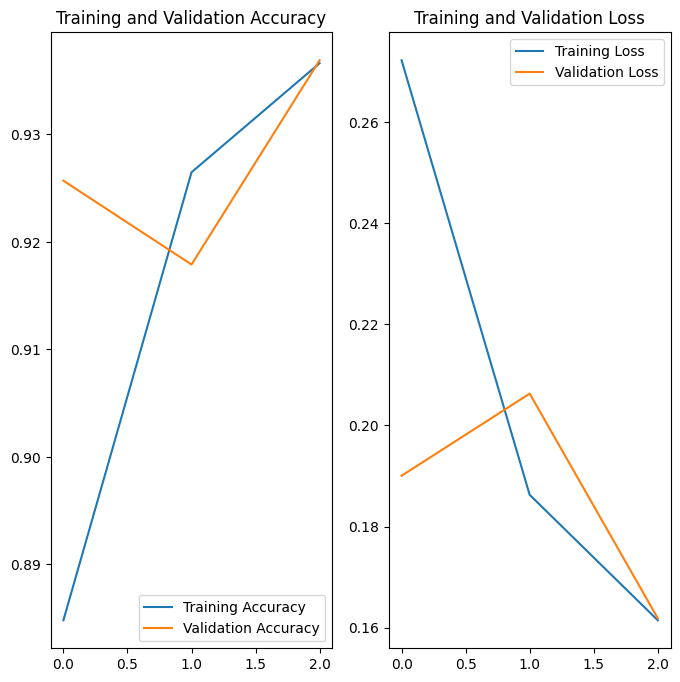

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# we see overfitting

Our first go has gotten great results! The accuracy after 3 epoch is ~94% and the training and test data converge to a very similar value! The loss of the train and test data also converge to a near identical value. There are no signs of over or under fitting so 3 epochs looks to be a good threshold. However, just for testing purposes we will try increasing the epochs and trying different activation functions.

Epoch 1/4
3125/3125 [==============================] - 177s 57ms/step - loss: 0.1447 - accuracy: 0.9437 - val_loss: 0.1550 - val_accuracy: 0.9374
Epoch 2/4
3125/3125 [==============================] - 176s 56ms/step - loss: 0.1290 - accuracy: 0.9500 - val_loss: 0.1509 - val_accuracy: 0.9430
Epoch 3/4
3125/3125 [==============================] - 142s 45ms/step - loss: 0.1172 - accuracy: 0.9552 - val_loss: 0.1569 - val_accuracy: 0.9413
Epoch 4/4
3125/3125 [==============================] - 146s 47ms/step - loss: 0.1050 - accuracy: 0.9596 - val_loss: 0.1700 - val_accuracy: 0.9354


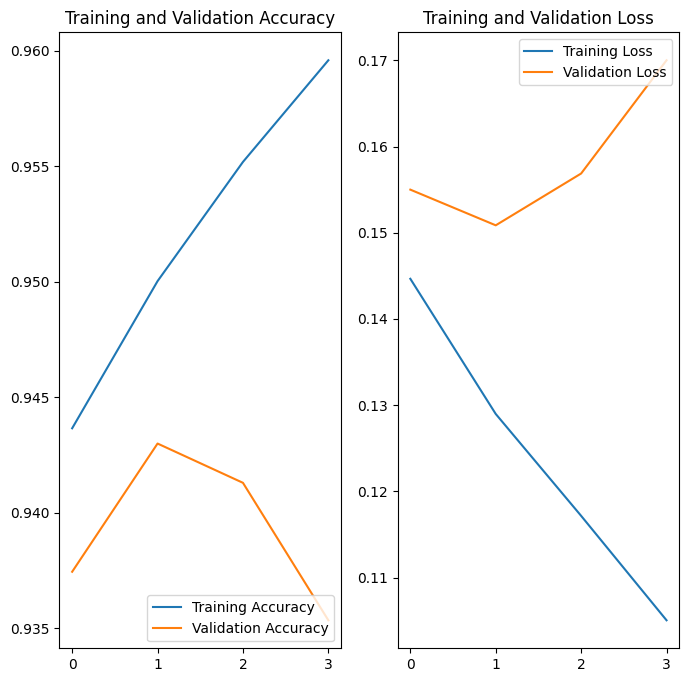

In [14]:
epochs=4 # change to 10 or a big number for grapghs to work
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



Increasing the epoch to 4 resulted as we expected, the training accuracy stayed relatively the same but the test accuracy took a dive. This further enforces 3 epochs as the correct number. The graph above shows massive overfitting and very high loss for the test data. So we know the correct epochs, next we will try another activation function. The function we will try is sigmoid, as the output layer is binary fake or real. 

In [15]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='sigmoid'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)         

Epoch 1/3
3125/3125 [==============================] - 151s 48ms/step - loss: 0.6458 - accuracy: 0.6024 - val_loss: 0.5359 - val_accuracy: 0.7307
Epoch 2/3
3125/3125 [==============================] - 152s 49ms/step - loss: 0.4336 - accuracy: 0.7963 - val_loss: 0.3740 - val_accuracy: 0.8311
Epoch 3/3
3125/3125 [==============================] - 150s 48ms/step - loss: 0.3418 - accuracy: 0.8504 - val_loss: 0.3194 - val_accuracy: 0.8642


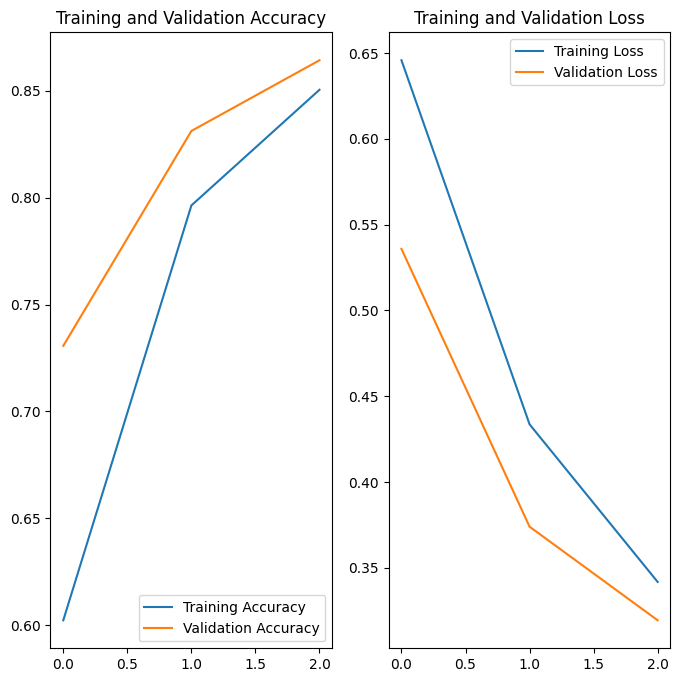

In [16]:
epochs=3 # change to 10 or a big number for grapghs to work
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs) 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()